Import packages

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
from astropy.visualization import ZScaleInterval
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import os
import glob
z = ZScaleInterval()


Sort files

In [2]:
data_path = "/Users/jcj/Documents/schoolwork/caltech/ay107/"
allfiles = [os.path.join(data_path, filestub[2:]) for filestub in glob.glob("./palomar_data/*.fits")]
files = {"dither": [], "science": [], "flat": [], "flat_dark": [], "dark": [], "arc": []}


for filename in allfiles:
    if filename[-8:-5].isnumeric():
        image_number = int(filename[-8:-5])
        
        if image_number < 630 and image_number > 511:
            files["science"].append(filename)
        if image_number == 505:
            files["science"].append(filename)
        if image_number < 511 and image_number > 505:
            files["dither"].append(filename)
        if image_number == 47:
            files["arc"].append(filename)
        if image_number < 59 and image_number > 47:
            files["flat"].append(filename)
        if image_number < 30 and image_number > 18:
            files["flat_dark"].append(filename)
        if image_number < 170 and image_number > 158:
            files["dark"].append(filename)

Make an observation log

In [5]:
columns = ["FILENAME", "FILEID", "FILETYPE", "RA", "DEC", "OBJECT", "TIME", "AIRMASS", "EXPTIME"]
filetypes = ["dither", "science", "flat", "flat_dark", "dark", "arc"]
data_dict = {}
for key in files:
    for filename in files[key]:
        current_header = fits.getheader(os.path.join(data_path, filename))
        image_number = int(filename[-8:-5])
        for col in columns:
            if col not in data_dict:
                data_dict[col] = []
            if col == "FILEID":
                data_dict[col].append(image_number)
                continue
            if col == "FILETYPE":
                data_dict[col].append(key)
                continue
            if col == "FILENAME" or col == "EXPTIME":
                if col == "FILENAME":
                    data_dict[col].append(os.path.join(data_path, filename))
                if col == "EXPTIME":
                    data_dict[col].append(current_header[col] * u.second)
            else:
                data_dict[col].append(current_header[col])

data_table = Table()
for key in data_dict:
    data_table[key] = data_dict[key]
data_table.group_by("FILEID").show_in_notebook()
data_table_by_type = data_table.group_by("FILETYPE")

Make a master dark for flats

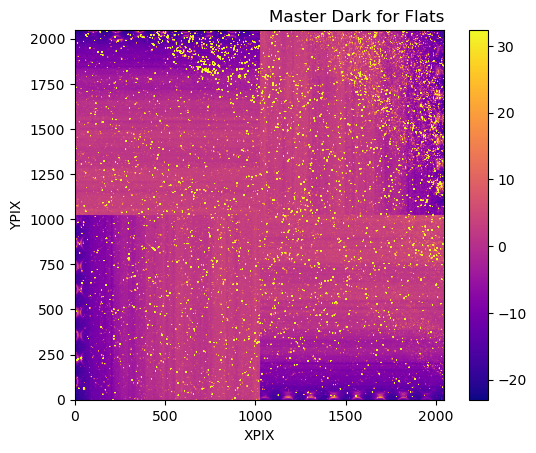

In [6]:
type_mask = data_table_by_type["FILETYPE"] == "flat_dark"
dark_table = data_table_by_type[type_mask]
dark_files = dark_table["FILENAME"]

dark_arrays = []
for dark in dark_files:
    dark_data = fits.getdata(dark)
    dark_arrays.append(dark_data)

master_flat_dark = np.median(dark_arrays, axis=0)
z1, z2 = z.get_limits(master_flat_dark)

fig, ax = plt.subplots()
cbar = ax.imshow(master_flat_dark, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Dark for Flats", loc="right")
ax.set_xlabel("XPIX")
ax.set_ylabel("YPIX")
plt.colorbar(cbar);

Make a master flat

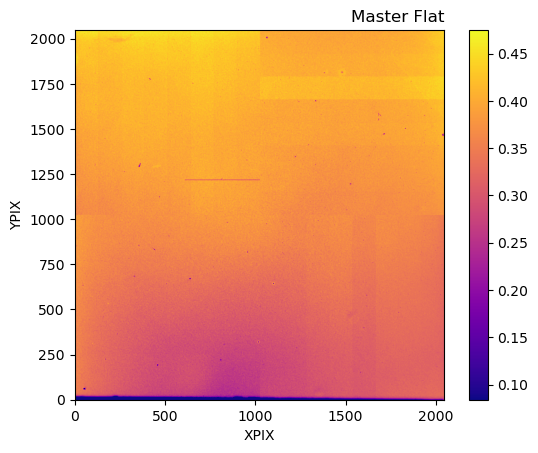

In [7]:
type_mask = data_table_by_type["FILETYPE"] == "flat"
flat_table = data_table_by_type[type_mask]
flat_files = flat_table["FILENAME"]

flat_arrays = []
for flat in flat_files:
    flat_data = fits.getdata(flat)
    flat_exposure = fits.getheader(flat)["EXPTIME"]
    norm_flat_data = (flat_data - master_flat_dark) / flat_exposure
    flat_arrays.append(norm_flat_data)

master_flat = np.median(flat_arrays, axis=0)
master_flat /= np.max(master_flat)
z1, z2 = z.get_limits(master_flat)

fig, ax = plt.subplots()
cbar = ax.imshow(master_flat, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Flat", loc="right")
ax.set_xlabel("XPIX")
ax.set_ylabel("YPIX")
plt.colorbar(cbar);

Make a master dark

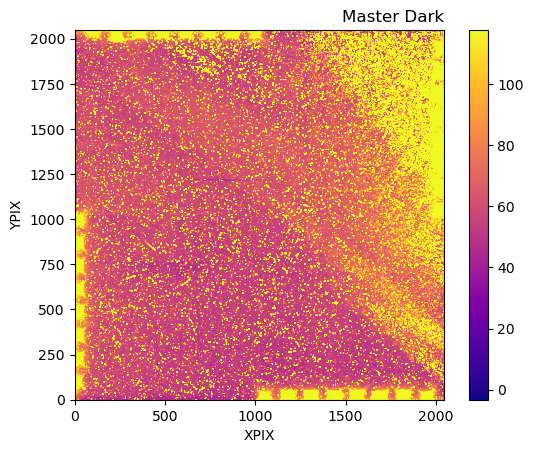

In [8]:
type_mask = data_table_by_type["FILETYPE"] == "dark"
dark_table = data_table_by_type[type_mask]
dark_files = dark_table["FILENAME"]

dark_arrays = []
for dark in dark_files:
    dark_data = fits.getdata(dark)
    #dark_exposure = fits.getheader(dark)["EXPTIME"]
    norm_dark_data = dark_data# / flat_exposure
    dark_arrays.append(norm_dark_data)

master_dark = np.median(dark_arrays, axis=0)
#master_flat /= np.max(master_flat)
z1, z2 = z.get_limits(master_dark)

fig, ax = plt.subplots()
cbar = ax.imshow(master_dark, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Dark", loc="right")
ax.set_xlabel("XPIX")
ax.set_ylabel("YPIX")
plt.colorbar(cbar);

Make a master sky background

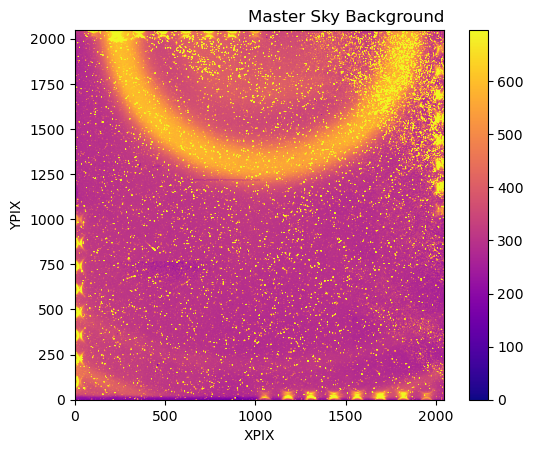

In [9]:
type_mask = data_table_by_type["FILETYPE"] == "dither"
dither_table = data_table_by_type[type_mask]
dither_files = dither_table["FILENAME"]

dither_arrays = []
for dither in dither_files:
    dither_data = fits.getdata(dither)
    dither_exposure = fits.getheader(dither)["EXPTIME"]
    norm_dither_data = (dither_data - master_flat_dark)
    dither_arrays.append(norm_dither_data)

master_sky = np.median(dither_arrays, axis=0)

z1, z2 = z.get_limits(master_sky)
fig, ax = plt.subplots()
cbar = ax.imshow(master_sky, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Sky Background", loc="right")
ax.set_xlabel("XPIX")
ax.set_ylabel("YPIX")
plt.colorbar(cbar);

Locate target

/var/folders/6k/l4_16kfs4pb8xt3kln55rrdw0000gn/T/ipykernel_65098/2472869232.py:6: RuntimeWarning: divide by zero encountered in divide
  red_science = (test_science - master_dark) / master_flat;
/var/folders/6k/l4_16kfs4pb8xt3kln55rrdw0000gn/T/ipykernel_65098/2472869232.py:6: RuntimeWarning: invalid value encountered in divide
  red_science = (test_science - master_dark) / master_flat;


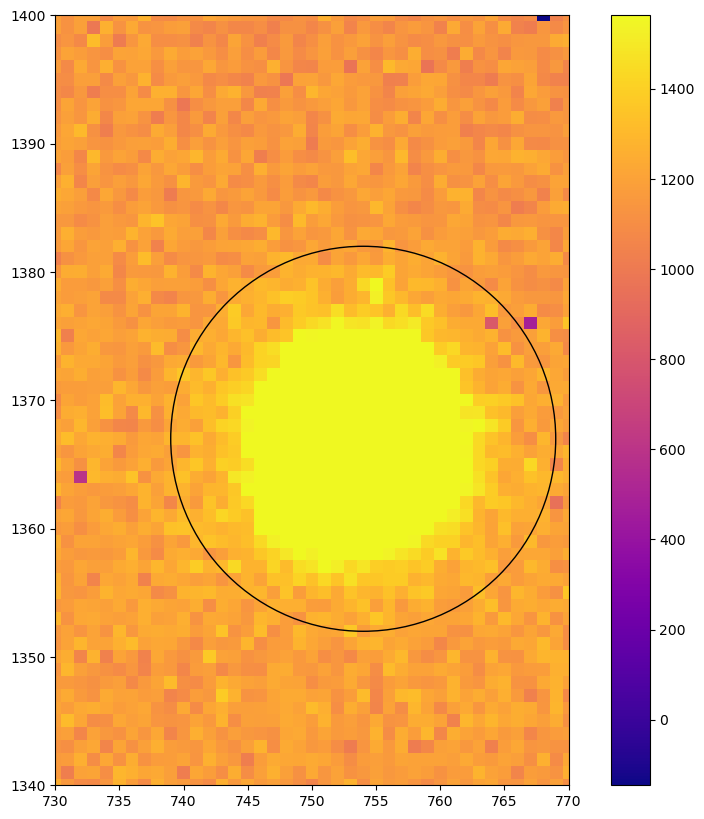

In [10]:
type_mask = data_table_by_type["FILETYPE"] == "science"
science_table = data_table_by_type[type_mask]
science_files = science_table["FILENAME"]
test_science = fits.getdata(science_files[0])

red_science = (test_science - master_dark) / master_flat;
x_center = 754
y_center = 1367

z1, z2 = z.get_limits(red_science)
fig, ax = plt.subplots()
fig.set_size_inches(11, 10)
cbar = ax.imshow(red_science, origin="lower", norm=Normalize(z1, z2), cmap="plasma")
targ_circle = plt.Circle((x_center, y_center), 15, fill=False)
ax.add_patch(targ_circle)
ax.set_xlim(730, 770)
ax.set_ylim(1340, 1400)
plt.colorbar(cbar);

Aperture photometry

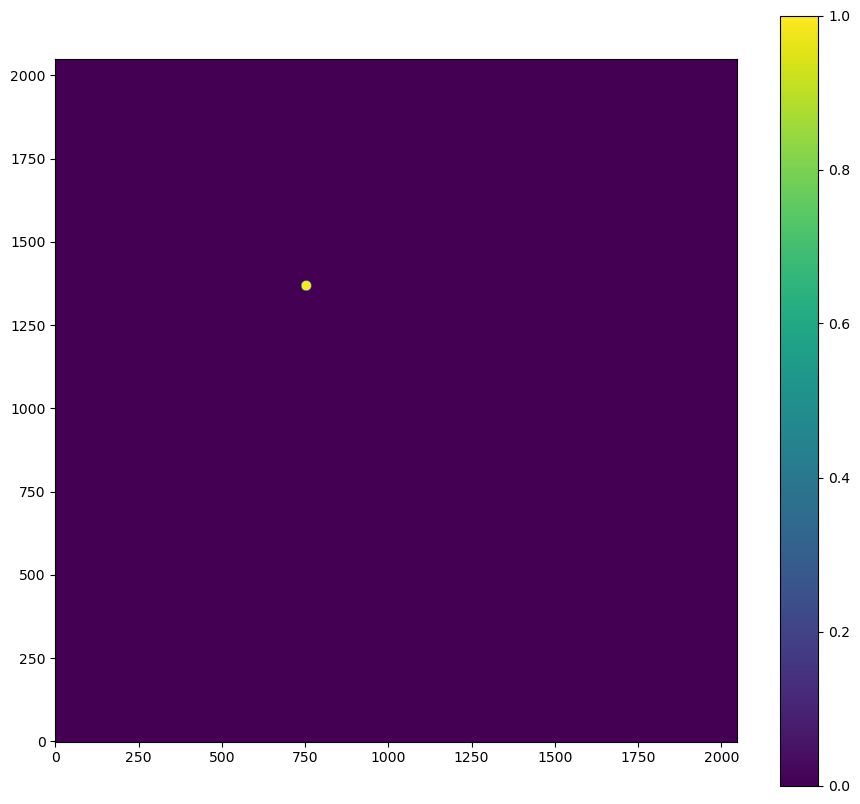

In [11]:
height = len(red_science)
width = len(red_science[0])
x_center = 753
y_center = 1368

def aperture_mask(h, w, radius, x_target, y_target):
    """ 
    Code that generates aperture mask
    """
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x_target)**2 + (Y-y_target)**2)

    mask = dist_from_center <= radius
    n_pix = np.sum(mask)
    return mask, n_pix

def annulus_mask(h, w, inner_radius, outer_radius, x_target, y_target):
    """ 
    Code that generates an annulus mask
    """
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x_target)**2 + (Y-y_target)**2)

    mask = (dist_from_center <= outer_radius) & (dist_from_center >= inner_radius)
    n_pix = np.sum(mask)
    return mask, n_pix

def calc_median(data, ann_mask, x_target, y_target, outer_radius):
    annular_data = np.multiply(data, ann_mask)
    annular_vals = []
    for x_idx in range(x_target - outer_radius, x_target + outer_radius + 1):
        for y_idx in range(y_target - outer_radius, y_target + outer_radius + 1):
            if annular_data[y_idx][x_idx] != 0:
                annular_vals.append(annular_data[y_idx][x_idx]) 
    return np.median(annular_vals)

mask, n_pix = aperture_mask(height, width, 15, x_center, y_center)
fig, ax = plt.subplots()
fig.set_size_inches(11, 10)
cbar = ax.imshow(mask, origin="lower")
plt.colorbar(cbar)

/var/folders/6k/l4_16kfs4pb8xt3kln55rrdw0000gn/T/ipykernel_65098/1576643981.py:9: RuntimeWarning: divide by zero encountered in divide
  red_science = (science_data - master_dark - master_sky) / master_flat
/var/folders/6k/l4_16kfs4pb8xt3kln55rrdw0000gn/T/ipykernel_65098/1576643981.py:9: RuntimeWarning: invalid value encountered in divide
  red_science = (science_data - master_dark - master_sky) / master_flat
/var/folders/6k/l4_16kfs4pb8xt3kln55rrdw0000gn/T/ipykernel_65098/1576643981.py:12: RuntimeWarning: invalid value encountered in multiply
  count = np.nansum(np.multiply(red_science, mask))


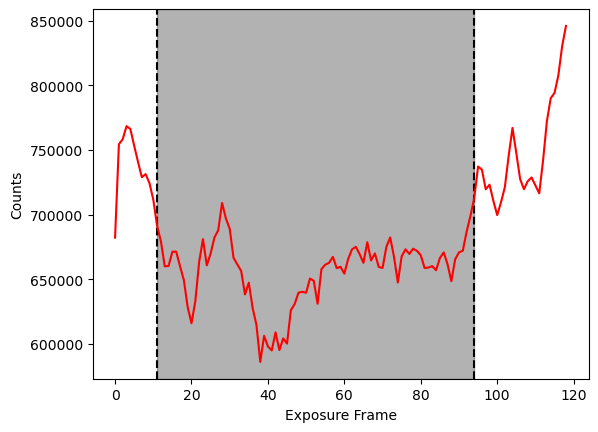

In [12]:
type_mask = data_table_by_type["FILETYPE"] == "science"
science_table = data_table_by_type[type_mask]
science_table.group_by("FILEID").show_in_notebook()
sorted_science_files = science_table.group_by("FILEID")["FILENAME"]

counts = []
for science_file in sorted_science_files:
    science_data = fits.getdata(science_file)
    red_science = (science_data - master_dark - master_sky) / master_flat
    ann_mask, ann_pix = annulus_mask(height, width, 13, 17, x_center, y_center)
    mask, n_pix = aperture_mask(height, width, 13, x_center, y_center)
    count = np.nansum(np.multiply(red_science, mask))
    counts.append(count)

x = np.arange(len(sorted_science_files))
fig, ax = plt.subplots()
ax.axvline(11, linestyle="dashed", color="black")
ax.axvline(94, linestyle="dashed", color="black")
ax.axvspan(11, 94, color="black", alpha=0.3)
ax.plot(x, counts, color="red");
ax.set_xlabel("Exposure Frame")
ax.set_ylabel("Counts");

In [13]:
science_table.group_by("FILEID").show_in_notebook()

idx,FILENAME,FILEID,FILETYPE,RA,DEC,OBJECT,TIME,AIRMASS,EXPTIME
,,,,,,,,,s
0,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0505.fits,505,science,16:52:53.08,+16:32:28.1,TOI-2109b,08:29:59.3,1.101,70.0
1,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0512.fits,512,science,16:52:44.73,+16:34:47.8,TOI-2109b,08:48:10.6,1.078,70.0
2,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0513.fits,513,science,16:52:44.71,+16:34:47.8,TOI-2109b,08:49:28.0,1.076,70.0
3,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0514.fits,514,science,16:52:44.70,+16:34:48.0,TOI-2109b,08:50:45.5,1.075,70.0
4,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0515.fits,515,science,16:52:44.68,+16:34:48.2,TOI-2109b,08:52:02.7,1.073,70.0
5,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0516.fits,516,science,16:52:44.66,+16:34:48.4,TOI-2109b,08:53:20.1,1.072,70.0
6,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0517.fits,517,science,16:52:44.66,+16:34:48.4,TOI-2109b,08:54:37.6,1.071,70.0
7,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0518.fits,518,science,16:52:44.64,+16:34:48.5,TOI-2109b,08:55:54.9,1.070,70.0
8,/Users/jcj/Documents/schoolwork/caltech/ay107/palomar_data/image0519.fits,519,science,16:52:44.62,+16:34:48.7,TOI-2109b,08:57:12.4,1.068,70.0
